In [2]:
pip install roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.8/83.8 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 20.1 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


In [1]:
pip install ultralytics

  Using cached ultralytics-8.3.88-py3-none-any.whl.metadata (35 kB)
  Using cached ultralytics_thop-2.0.14-py3-none-any.whl.metadata (9.4 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.m

In [43]:
import os
import cv2
import matplotlib.pyplot as plt
import yaml
import torch
from roboflow import Roboflow
import seaborn as sns
from collections import Counter
import pandas as pd
import numpy as np
import glob

In [4]:
from ultralytics import YOLO

In [5]:



rf = Roboflow(api_key="gMu18twOPMgwp22tEQfY")
project = rf.workspace("sayed-gamall").project("fire-smoke-detection-yolov11")
version = project.version(2)
dataset = version.download("yolov11")



loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Fire-Smoke-Detection-Yolov11-2 in yolov11:: 100%|██████████| 20938/20938 [00:03<00:00, 5371.12it/s]


In [6]:
#  -----  CODE IN THIS CELL WRITTEN BY SAYED GAMALL IN HIS IMPLEMENTATION OF THIS PROJECT  -----

# Path to the YAML file
file_path = f'{dataset.location}/data.yaml'

# Step 1: Read the YAML file
with open(file_path, 'r') as file:
    data = yaml.safe_load(file)

# Step 2: Update paths for train, val, and test
base_path = dataset.location
data['train'] = f"{base_path}/train/images"
data['val'] = f"{base_path}/valid/images"
data['test'] = f"{base_path}/test/images"

# Step 3: Save the updated YAML data back to the file
with open(file_path, 'w') as file:
    yaml.safe_dump(data, file, default_flow_style=False)

print("Paths updated successfully!")

Paths updated successfully!


In [56]:
from pprint import pprint

with open(file_path, 'r') as file:
    data = yaml.safe_load(file)

pprint(data)

{'names': ['Fire', 'Smoke'],
 'nc': 2,
 'roboflow': {'license': 'CC BY 4.0',
              'project': 'fire-smoke-detection-yolov11',
              'url': 'https://universe.roboflow.com/sayed-gamal-kn2wu/fire-smoke-detection-yolov11/dataset/2',
              'version': 2,
              'workspace': 'sayed-gamal-kn2wu'},
 'test': '/content/Fire-Smoke-Detection-Yolov11-2/test/images',
 'train': '/content/Fire-Smoke-Detection-Yolov11-2/train/images',
 'val': '/content/Fire-Smoke-Detection-Yolov11-2/valid/images'}


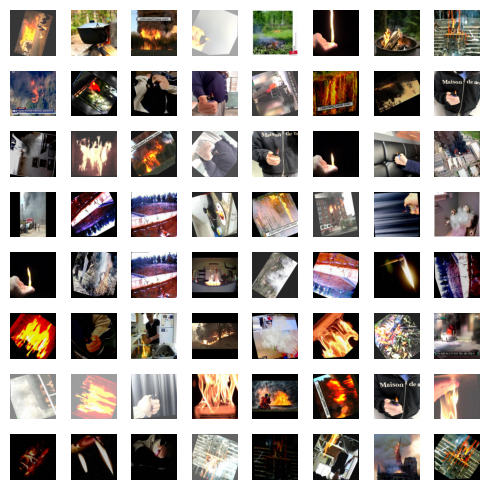

(640, 640, 3)


In [11]:
# visualise dataset

# Define dataset image path
image_folder = f"{dataset.location}/train/images"

# Get the first few image filenames 8*8=64 in our case here
image_files = [f for f in os.listdir(image_folder) if f.endswith(('.jpg', '.png', '.jpeg'))][:64]

# Set up plot grid (8*8)
fig, axes = plt.subplots(8, 8, figsize=(5, 5))

# Loop through and plot images
for i, ax in enumerate(axes.flat):
    if i < len(image_files):
        img_path = os.path.join(image_folder, image_files[i])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        ax.axis("off")

plt.tight_layout()
plt.show()
print(img.shape)

# **Class Distribution**

In [57]:
class_counts = Counter()
bounded_boxes = []

label_folder_train = '/content/Fire-Smoke-Detection-Yolov11-2/train/labels'
label_folder_val = '/content/Fire-Smoke-Detection-Yolov11-2/valid/labels'
label_folder_test = '/content/Fire-Smoke-Detection-Yolov11-2/test/labels'


def get_class_distribution(label_folder):
  annotation_files = glob.glob(os.path.join(label_folder, '*.txt'))

  # Open the directory
  for filename in annotation_files:
      with open(filename, 'r') as f:
        lines = f.readlines()
        for line in lines:
          # split into probability + 4 bounded box columns for a total of 5
          segments = line.strip().split()

          # some will have more than one bounded box so we have to process in chunks of 5?
          if len(segments) == 5:
              class_id = int(segments[0])
              x_center, y_center, width, height = map(float, segments[1:])
              class_counts[class_id] += 1
              bounded_boxes.append([x_center, y_center, width, height])
          else:
              print(len(segments), "Skipping line with unexpected format:", segments)

  return class_counts, bounded_boxes

class_counts, bounded_boxes = get_class_distribution(label_folder_train)

# convert to dataframe for plotting
box_df = pd.DataFrame(bounded_boxes, columns=['x_center', 'y_center', 'width', 'height'])

19 Skipping line with unexpected format: ['1', '0.67537895625', '0', '0.0057170796874999995', '0.16371573749999999', '0.007424328125', '0.2126049390625', '0.21670524218749998', '0.9978847468750001', '0.505797859375', '0.9945208484375', '1', '0.8737006671875', '1', '0.37334458125', '0.900501840625', '0', '0.67537895625', '0']
11 Skipping line with unexpected format: ['1', '0.6515625', '0.0140625', '0.09375', '0.0140625', '0.09375', '0.675', '0.6515625', '0.675', '0.6515625', '0.0140625']
17 Skipping line with unexpected format: ['1', '0.1667996765625', '0', '0', '0.49905177187499994', '0', '0.8640290296875', '0.44031042343750004', '0.9972690671875', '0.7245081375', '0.995615653125', '0.9809156265625001', '0.2284642140625', '0.2259235375', '0', '0.1667996765625', '0']
17 Skipping line with unexpected format: ['1', '0.23143011093750002', '0', '0.0871858125', '0.8458763140625001', '0.877584553125', '0.9850879765625', '0.9354434515625', '0.9840780453125', '1', '0.6055060265625001', '1', '0.

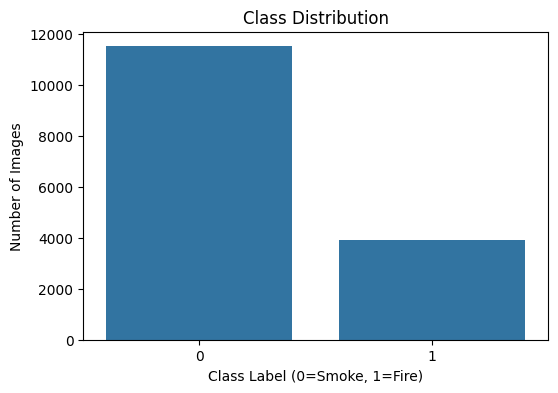

In [59]:
plt.figure(figsize=(6,4))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title('Class Distribution')
plt.xlabel('Class Label (0=Smoke, 1=Fire)')
plt.ylabel('Number of Images')
plt.xticks([0, 1])
plt.show()

Text(0, 0.5, 'Frequency')

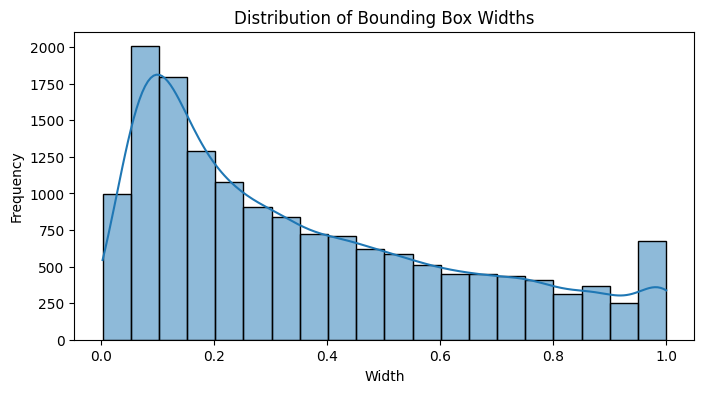

In [58]:
plt.figure(figsize=(8,4))
sns.histplot(box_df['width'], bins=20, kde=True)
plt.title('Distribution of Bounding Box Widths')
plt.xlabel('Width')
plt.ylabel('Frequency')

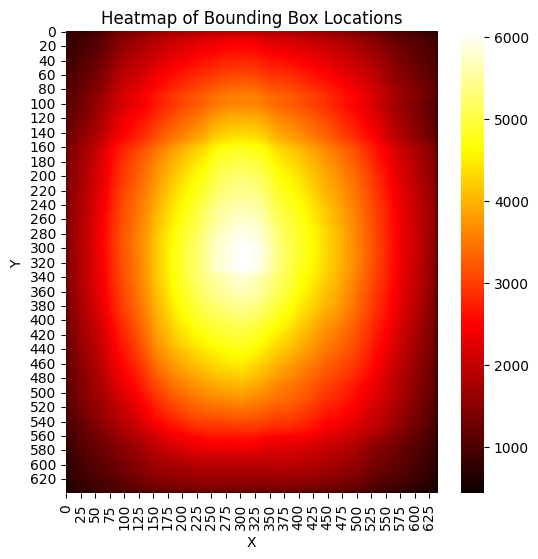

In [60]:
heatmap = np.zeros((640, 640))

for _, row in box_df.iterrows():
  x,y,w,h = row['x_center'], row['y_center'], row['width'], row['height']
  x1, y1 = int((x - w/2) * 640), int((y - h/2) * 640)
  x2, y2 = int((x + w/2) * 640), int((y + h/2) * 640)
  heatmap[y1:y2, x1:x2] += 1

plt.figure(figsize=(6,6))
sns.heatmap(heatmap, cmap='hot', cbar=True)
plt.title('Heatmap of Bounding Box Locations')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# **Example Implementation using ulatralytics' yolo11n.pt.train()**

In [8]:


# model = YOLO("yolo11n.pt")
# print("GPU Available:", torch.cuda.is_available())
# print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

In [9]:
# Example model using ultralytics' yolo.train()

# # Train YOLO on your dataset
# model.train(data=f"{dataset.location}/data.yaml", epochs=20, batch=16, imgsz=640, device='cuda')